In [1]:
import jax
import os



os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
print(jax.local_devices())

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm

from utils_optim import kernel_linear_solver

[cuda(id=0)]


In [2]:
plt.style.use('plot_style-Examples_3d.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [3]:
from jax.scipy import integrate
def compute_2d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(integrate.trapezoid(u**2, x), y))
    norm_diff = jnp.sqrt(integrate.trapezoid(integrate.trapezoid((pred - u)**2, x), y))
    return norm_diff, norm_diff/norm_u

def compute_1d_error(pred, u, x):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

In [4]:
def implicit_EM_solver(time_span, h, linear_solver, y_init,non_linear_init, sigma, BM_proj, tau, k_quad, tent_quad):

    y = y_init
    non_linear = non_linear_init

    #noise = []
    c_history = []
    print("Number of steps {}".format(time_span.shape[0]))
    for i,t  in tqdm(enumerate(time_span)):
        # Sample from the space time white noise
        xi = BM_proj[:, i]


        # Create the right hand side
        #bp()
        rhs = y + h*non_linear+ jnp.sqrt(h)*sigma*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, None, None, compute_residuals = False)

    

        c_history.append(linear_solver.c)    

        values_quad = linear_solver.evaluate_solution_predef(k_quad)
        # Project on the tent functions
        non_linear = integrate_f_test_functions(tau(values_quad), tent_quad)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()#integrate_f_test_functions(values_quad, tent_quad)


    return y, linear_solver, jnp.array(c_history)

In [5]:
@jit
def integrate_f_test_functions(f_values, psi):
    # Psi should be a matrix containing the values of the weighted test functions at the quadrature points
    return f_values@psi
vmap_integrate_f_test_functions = jit(vmap(integrate_f_test_functions, in_axes=(0,None)))

# Benchmark: stochastic Allen-Cahn with spectral decomposition


We will solve the Allen Cahn equation

\begin{align}
&du = (\nu \Delta u + bu - u^3)dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

This leads to the following disretization:

\begin{align}
&(-h \nu\Delta + (1-bh)I )u_{n+1} = u_n - hu_n^3 + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

Let 
$$
u = \sum_{j=1}^\infty u_j(t)  \sqrt{2}\sin(j\pi x)
$$

\begin{align}
[(-h \nu\Delta + (1-bh)I )u_{n+1}, \psi] = [u_n,\psi] + h[f(u_n), \psi]+ \sqrt{h}[\Delta \xi_n, \psi]
\end{align}

The term 

$$
[f(u_n), \psi]
$$
can be efficiently computed using the DST.



CFL condition: we need 

$$
\lambda_N h = C
$$
where $h$ is the timestep.
But

$$
\lambda_N = \nu\pi^2 N^2
$$

Hence we need 

$$
\nu\pi^2 N^2 h = C
$$

Hence we would like to choose

$$
N^2 h = \frac{1}{\nu\pi^2}
$$

In practice this is difficult to do.

In [6]:
from utils_DST import discrete_sine_transform, vmap_dst, vmap_compute_sine_coef, compute_sine_coefficients

In [7]:
nu = 1e-4
h_spectral  =  2**(-12)
T = 10.0 //h_spectral * h_spectral
print(T)
sigma = 0.01
time_span = jnp.arange(0, T, h_spectral) + h_spectral


n_coef = 2**11#int(jnp.sqrt(1/h_spectral))*50
n_coef, h_spectral

10.0


(2048, 0.000244140625)

In [8]:
# tau = jit(lambda x: x -x**3)
# def spectral_implicit_EM_solver(A, b, h, time_span, y_init, sigma, BM):

#     y = y_init
#     n = y_init.shape[0]

#     #L = scipy.linalg.cho_factor(A + (1-b*h)*jnp.eye(n))
#     A_inv = jnp.diag((h*A + jnp.ones(n))**-1)

#     #noise = []
#     y_history = []
#     print("Number of steps {}".format(time_span.shape[0]))
#     for i,t  in tqdm(enumerate(time_span)):
#         # Sample from the space time white noise
#         xi = BM[:, i]

#         # Evaluate the non linearity in the physical domain
#         non_linear = tau(discrete_sine_transform(y))
#         # Compute the Fourier coefficients
#         non_linear = compute_sine_coefficients(non_linear)

#         # Create the right hand side
#         rhs = y + non_linear*h +sigma*xi
#         y =A_inv@rhs
#         y_history.append(y)


#     return y, jnp.array(y_history)

In [9]:
def implicit_EM_solver(time_span, h, linear_solver, y_init,non_linear_init, sigma, BM_proj, tau, k_quad, tent_quad):

    y = y_init
    non_linear = non_linear_init

    #noise = []
    c_history = []
    print("Number of integration steps {}".format(time_span.shape[0]))
    for i,t  in tqdm(enumerate(time_span)):
        # Sample from the space time white noise
        xi = BM_proj[:, i]


        # Create the right hand side
        rhs = y + h*non_linear+ jnp.sqrt(h)*sigma*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, None, None, compute_residuals = False)

    

        c_history.append(linear_solver.c)    

        values_quad = linear_solver.evaluate_solution_predef(k_quad)
        # Project on the tent functions
        non_linear = integrate_f_test_functions(tau(values_quad), tent_quad)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()#integrate_f_test_functions(values_quad, tent_quad)


    return y, linear_solver, jnp.array(c_history)

In [10]:
tau = jit(lambda x: -x**3)
def spectral_implicit_EM_solver(A, h, time_span, y_init, sigma, BM):

    y = y_init
    n = y_init.shape[0]

    #L = scipy.linalg.cho_factor(A + (1-b*h)*jnp.eye(n))
    A_inv = jnp.diag((h*A + (1-h)*jnp.ones(n))**-1)

    #noise = []
    y_history = []
    print("Number of steps {}".format(time_span.shape[0]))
    for i,t  in tqdm(enumerate(time_span)):
        # Sample from the space time white noise
        xi = BM[:, i]

        # Evaluate the non linearity in the physical domain
        non_linear = tau(discrete_sine_transform(y))
        # Compute the Fourier coefficients
        non_linear = compute_sine_coefficients(non_linear)

        # Create the right hand side
        rhs = y + non_linear*h +jnp.sqrt(h)*sigma*xi
        y =A_inv@rhs
        y_history.append(y)


    return y, jnp.array(y_history)

In [11]:
key = random.PRNGKey(103)


upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1

# This is the initial condition
coef_g = jnp.zeros(n_coef) #jnp.hstack([random.normal(key, shape= (n_coef,))])/(0.01*frequencies**(2+0.5)*jnp.pi**2  +1)
coef_g = coef_g.at[1].set(1.0)*0.1

g_values = discrete_sine_transform(coef_g)
A= nu*jnp.pi**2*jnp.arange(1, n_coef+1)**2

BM = random.normal(random.PRNGKey(0), (n_coef, time_span.shape[0]))

2048


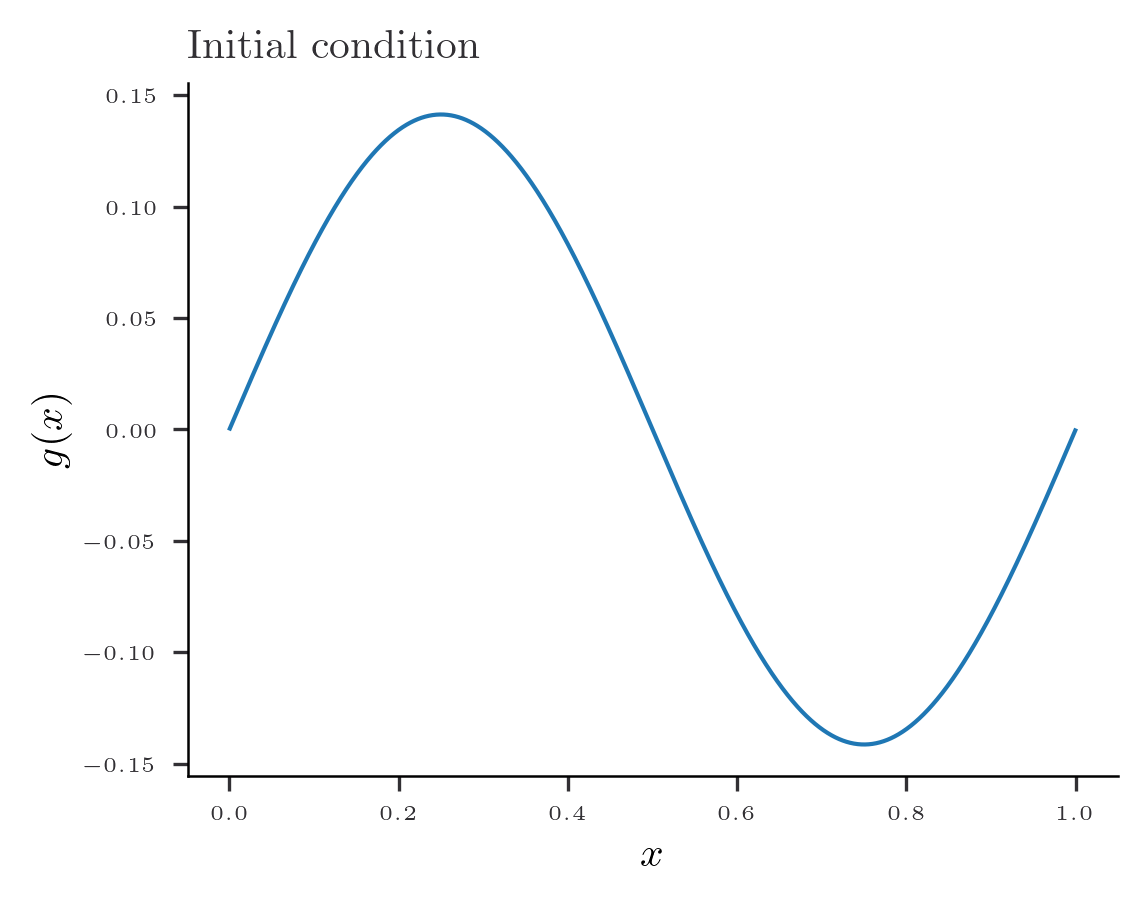

In [12]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [13]:
start = time.time()
u_final, u_history = spectral_implicit_EM_solver(A, h_spectral, time_span, coef_g,  sigma, BM)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Number of steps 40960


40960it [09:31, 71.71it/s] 
2024-07-03 12:36:33.603126: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.0KiB (rounded to 262144)requested by op 
2024-07-03 12:36:33.685698: W external/tsl/tsl/framework/bfc_allocator.cc:494] ****************************************************************************************************
E0703 12:36:33.686113 3455415 pjrt_stream_executor_client.cc:2826] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 262144 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   256.0KiB
              constant allocation:         0B
        maybe_live_out allocation:   256.0KiB
     preallocated temp allocation:         0B
                 total allocation:   512.0KiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 256.0KiB
		Operator: op_name="jit(concatenate)/jit(main)/concaten

In [ ]:
u_final_values = discrete_sine_transform(u_final)
u_values_T = vmap_dst(u_history)

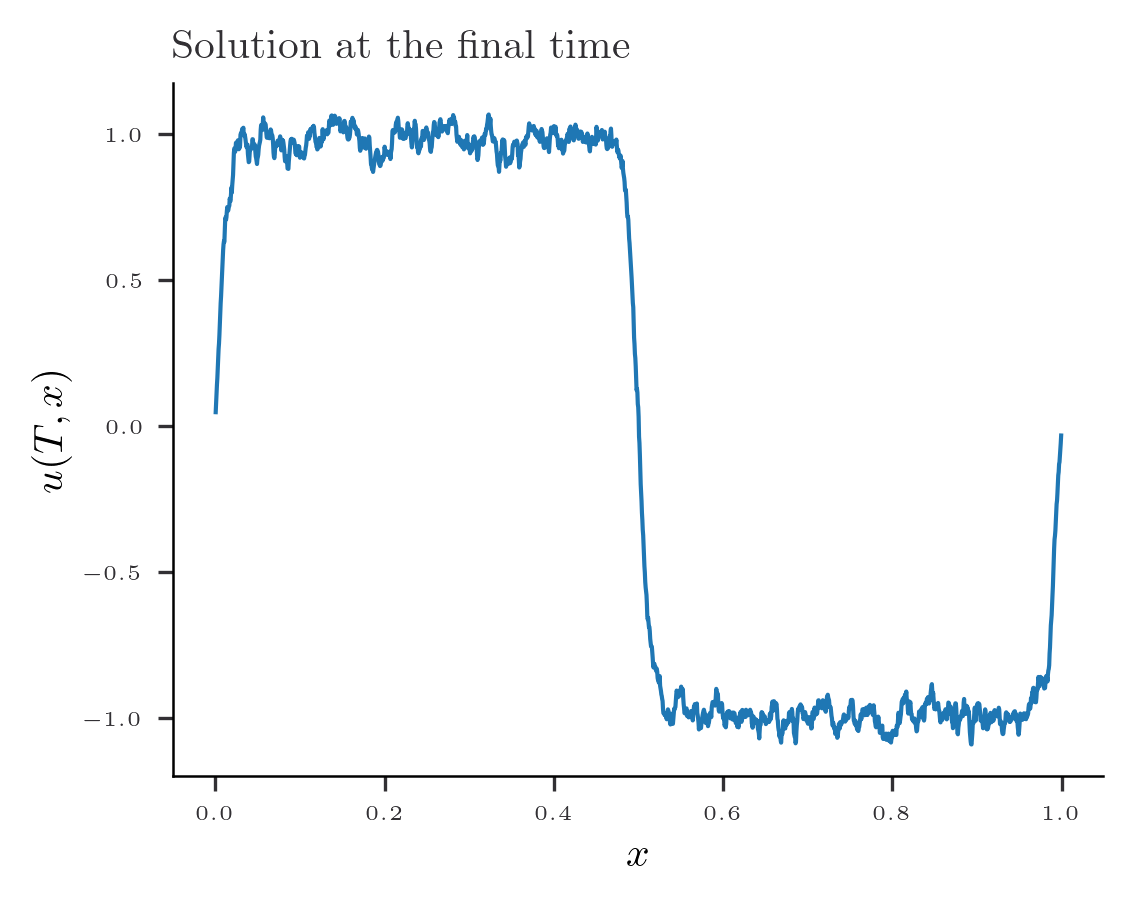

In [ ]:

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_final_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(T, x)$")
plt.title(r"Solution at the final time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

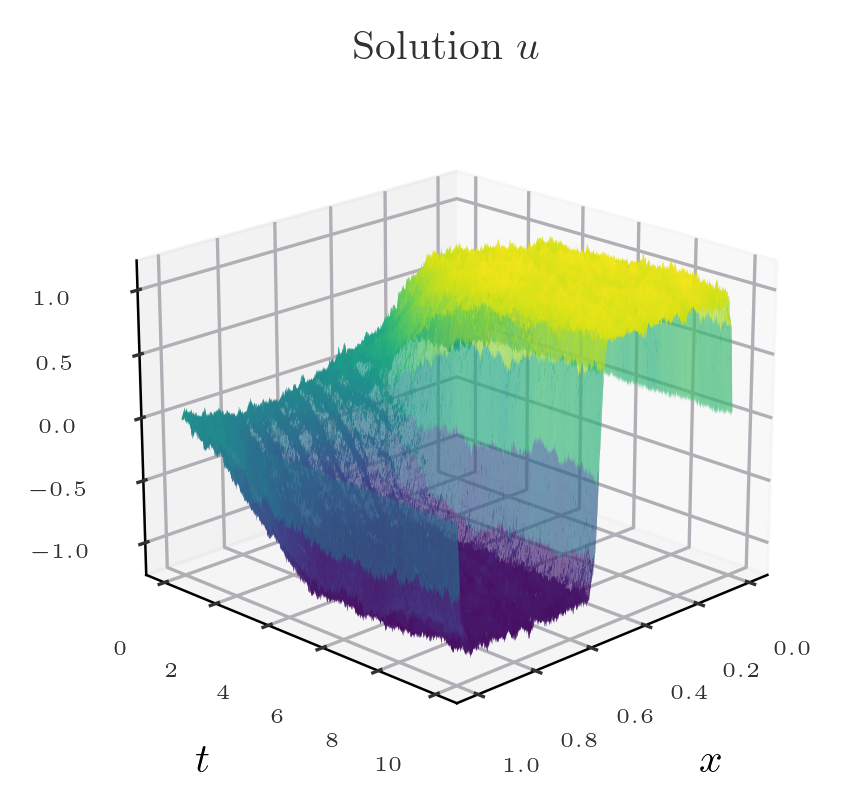

In [ ]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
stride = 25
ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis',  rstride=stride, cstride=stride)


#ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis')


#ax.plot_surface(X, time_grid, u_values_T,  cmap='viridis')
ax.set_title(r"Solution $u$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

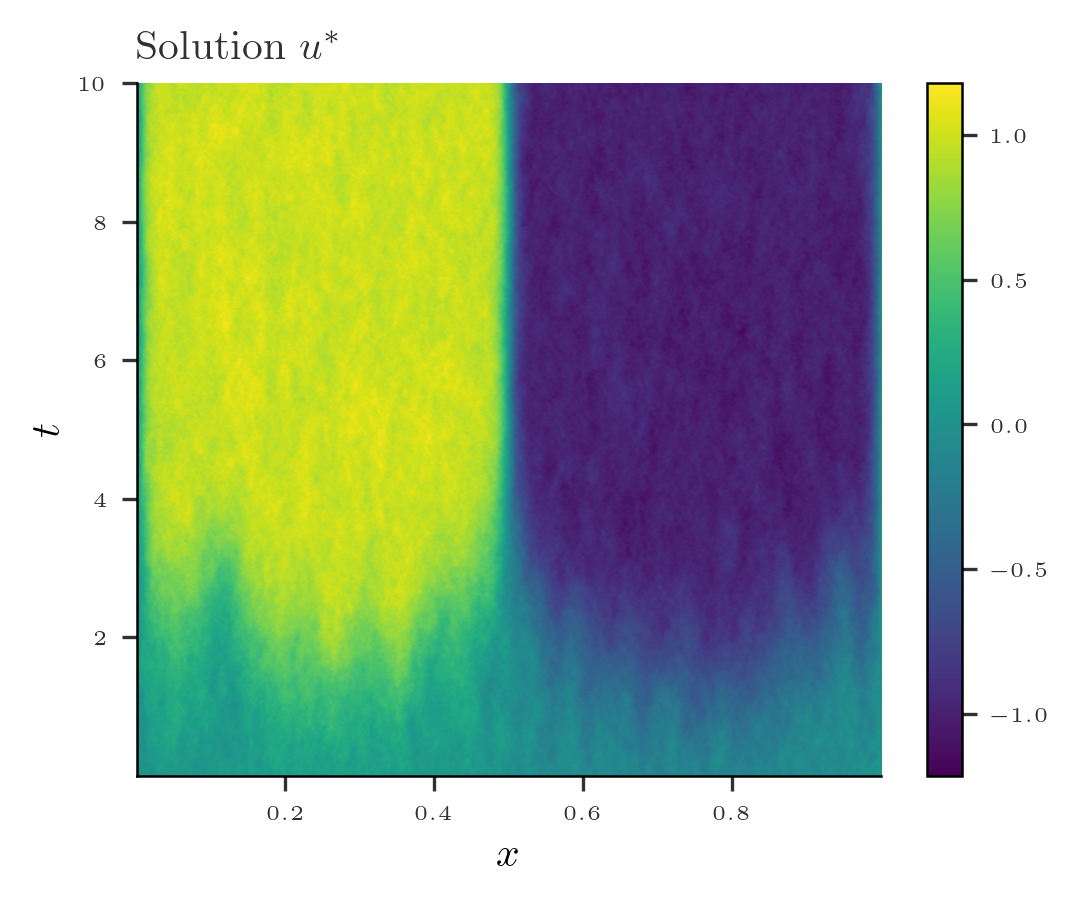

In [ ]:
fig = plt.figure(figsize=(width, height))

plt.imshow(u_values_T[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span.min(), time_span.max()], aspect='auto')
#plt.imshow(u_values_T[::100], cmap='viridis')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Solution $u^*$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Coarser in space

In [18]:
coarse_factor = 1 # Here the coarse factor is 1 (so we have the same resolution in time)
h = h_spectral*coarse_factor
time_span = jnp.arange(h, T+h, h)
time_span_spectral = jnp.arange(h_spectral, T+h_spectral, h_spectral)
cfl_factor = 3

In [19]:
# Generate our Galerkin basis
n_intervals = int(jnp.sqrt(1/h))*cfl_factor + 1
n_meas = n_intervals -1 # We do not include the boundary points
print(n_meas)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

192


In [20]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

n_quad = 3
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))


# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

5


In [21]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

In [22]:
@jit
def integrate_f_test_functions(f_values, psi):
    # Psi should be a matrix containing the values of the weighted test functions at the quadrature points
    return f_values@psi
vmap_integrate_f_test_functions = jit(vmap(integrate_f_test_functions, in_axes=(0,None)))

In [23]:
g_quad = jnp.sqrt(2)*jnp.sin(2*jnp.pi*k_quad)*0.1
non_linear_init =integrate_f_test_functions(tau(g_quad), tent_quad) 
g_proj = integrate_f_test_functions(g_quad, tent_quad)

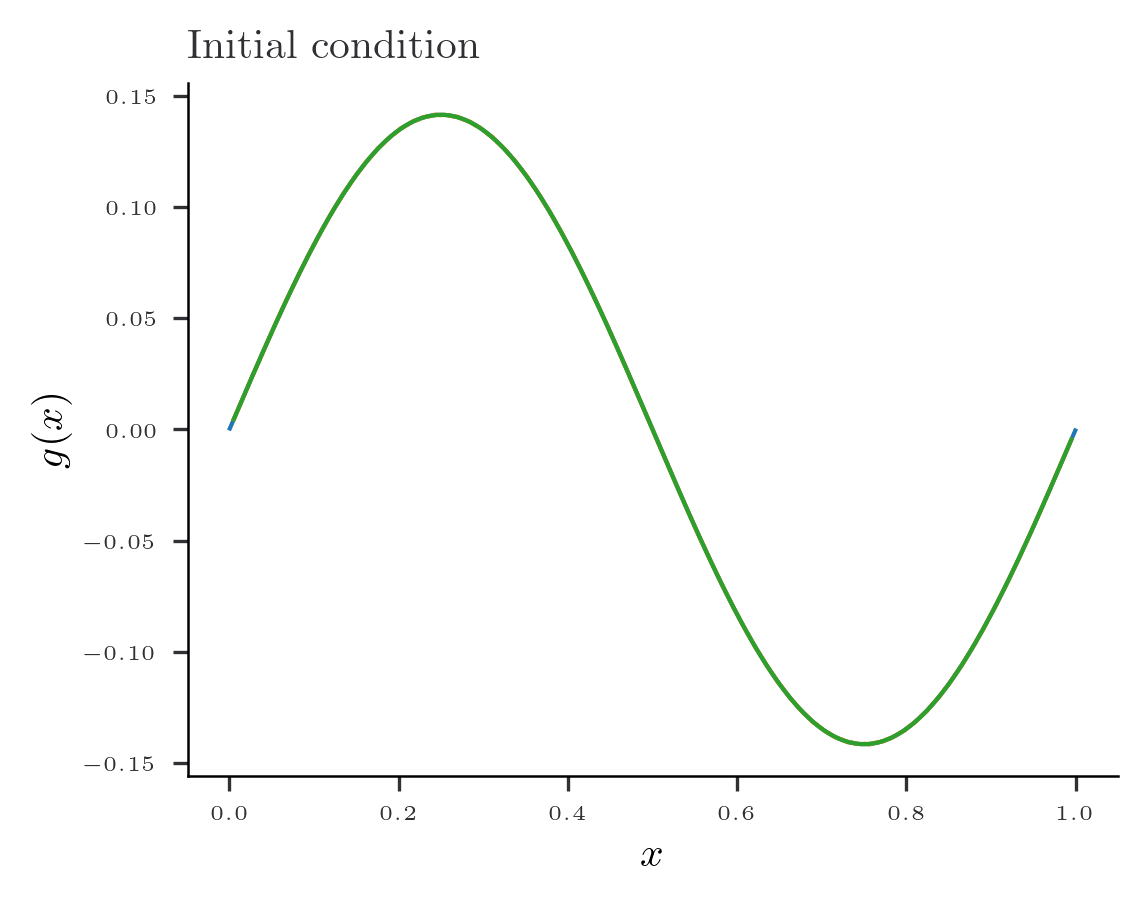

In [24]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.plot(centers[1:-1], g_tent)
plt.plot(centers[1:-1], g_proj)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [25]:
b =lambda x : jnp.ones_like(x)*(1-h)
root_b= b(k_quad)
length_scale = 0.01
k_quad.shape

(192, 6)

In [26]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)


start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 6.4230100000000006


In [27]:
BM_coarse = BM.reshape(n_coef, time_span_spectral.shape[0] // coarse_factor, coarse_factor)
BM_coarse = jnp.sum(BM_coarse, axis = -1)/jnp.sqrt(coarse_factor)
xi_tent_coarse = tent_proj_coef@BM_coarse
white_noise = vmap_dst(BM.T)

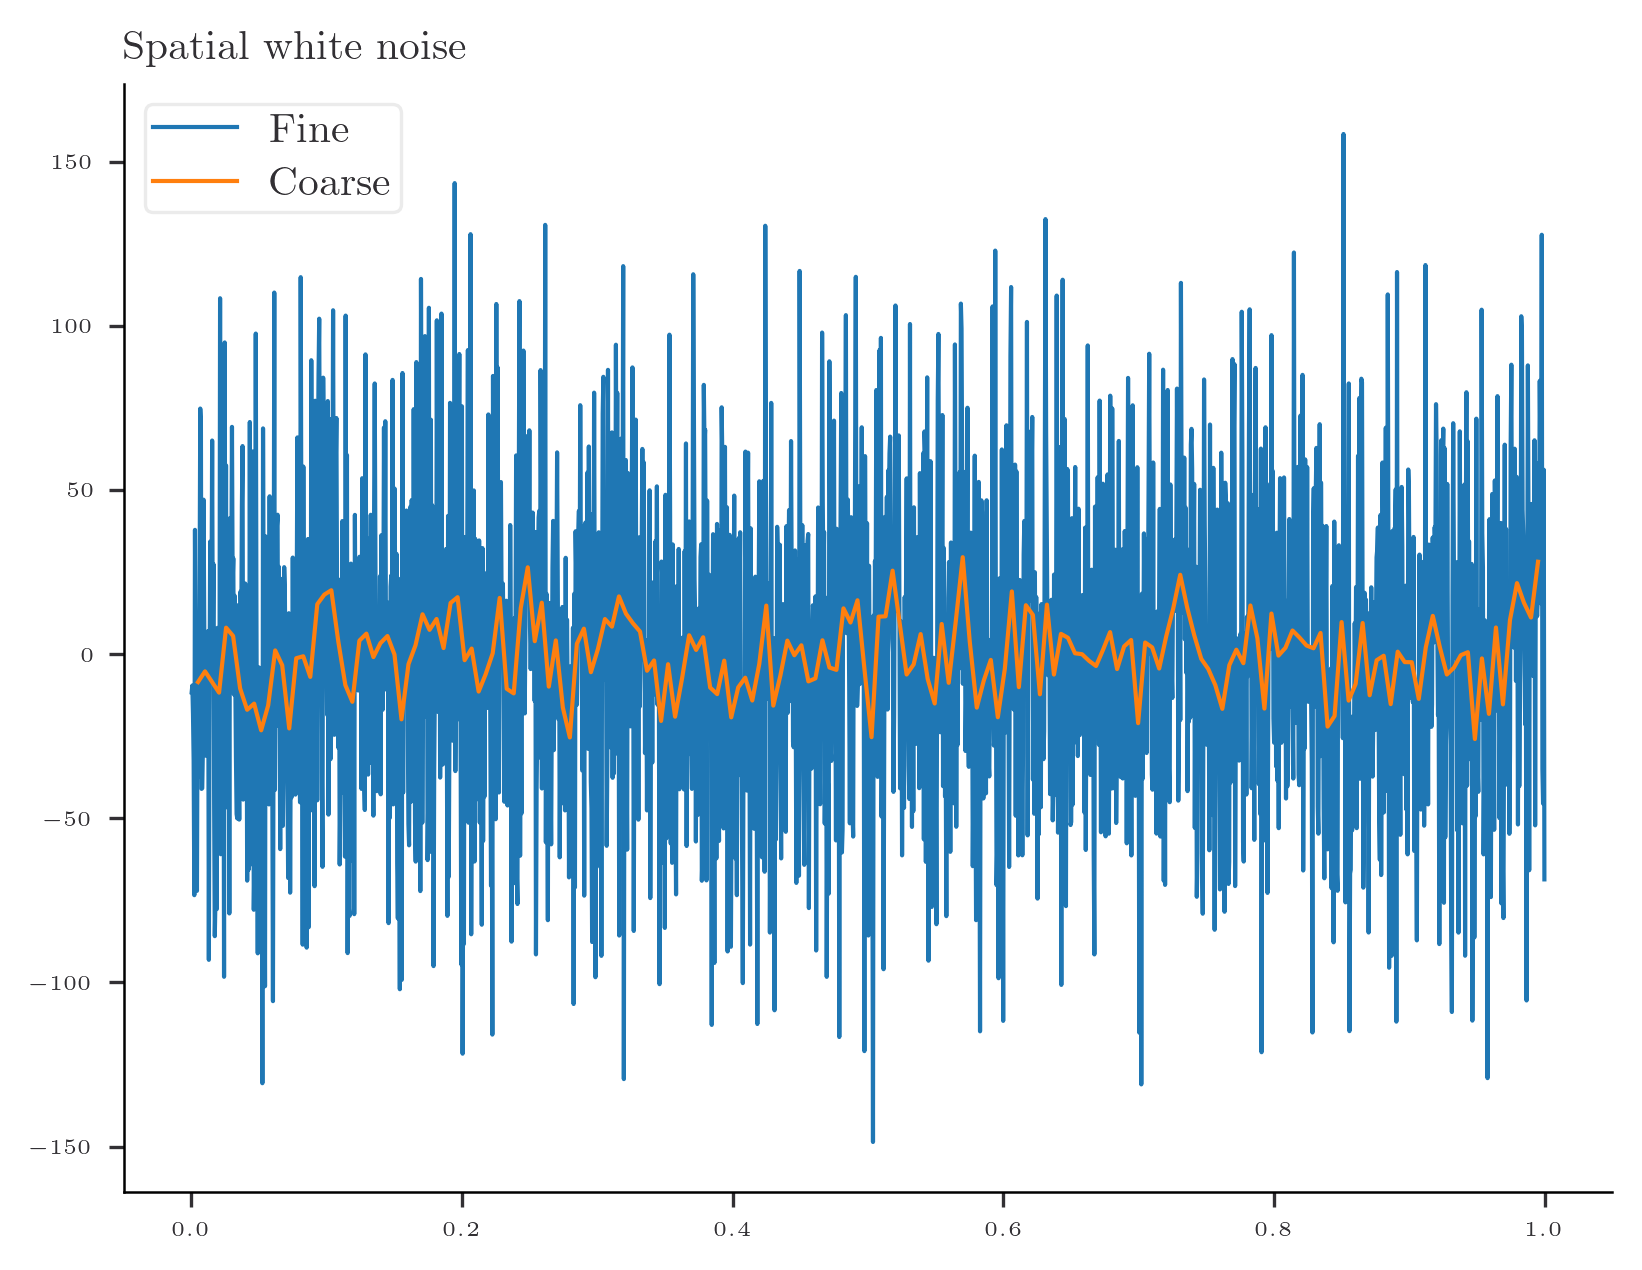

In [28]:
plt.plot(domain_finest, white_noise[0], label = "Fine")
plt.plot(centers[1:-1], xi_tent_coarse[:, 0], label = "Coarse")
plt.legend()
plt.title("Spatial white noise")
plt.show()

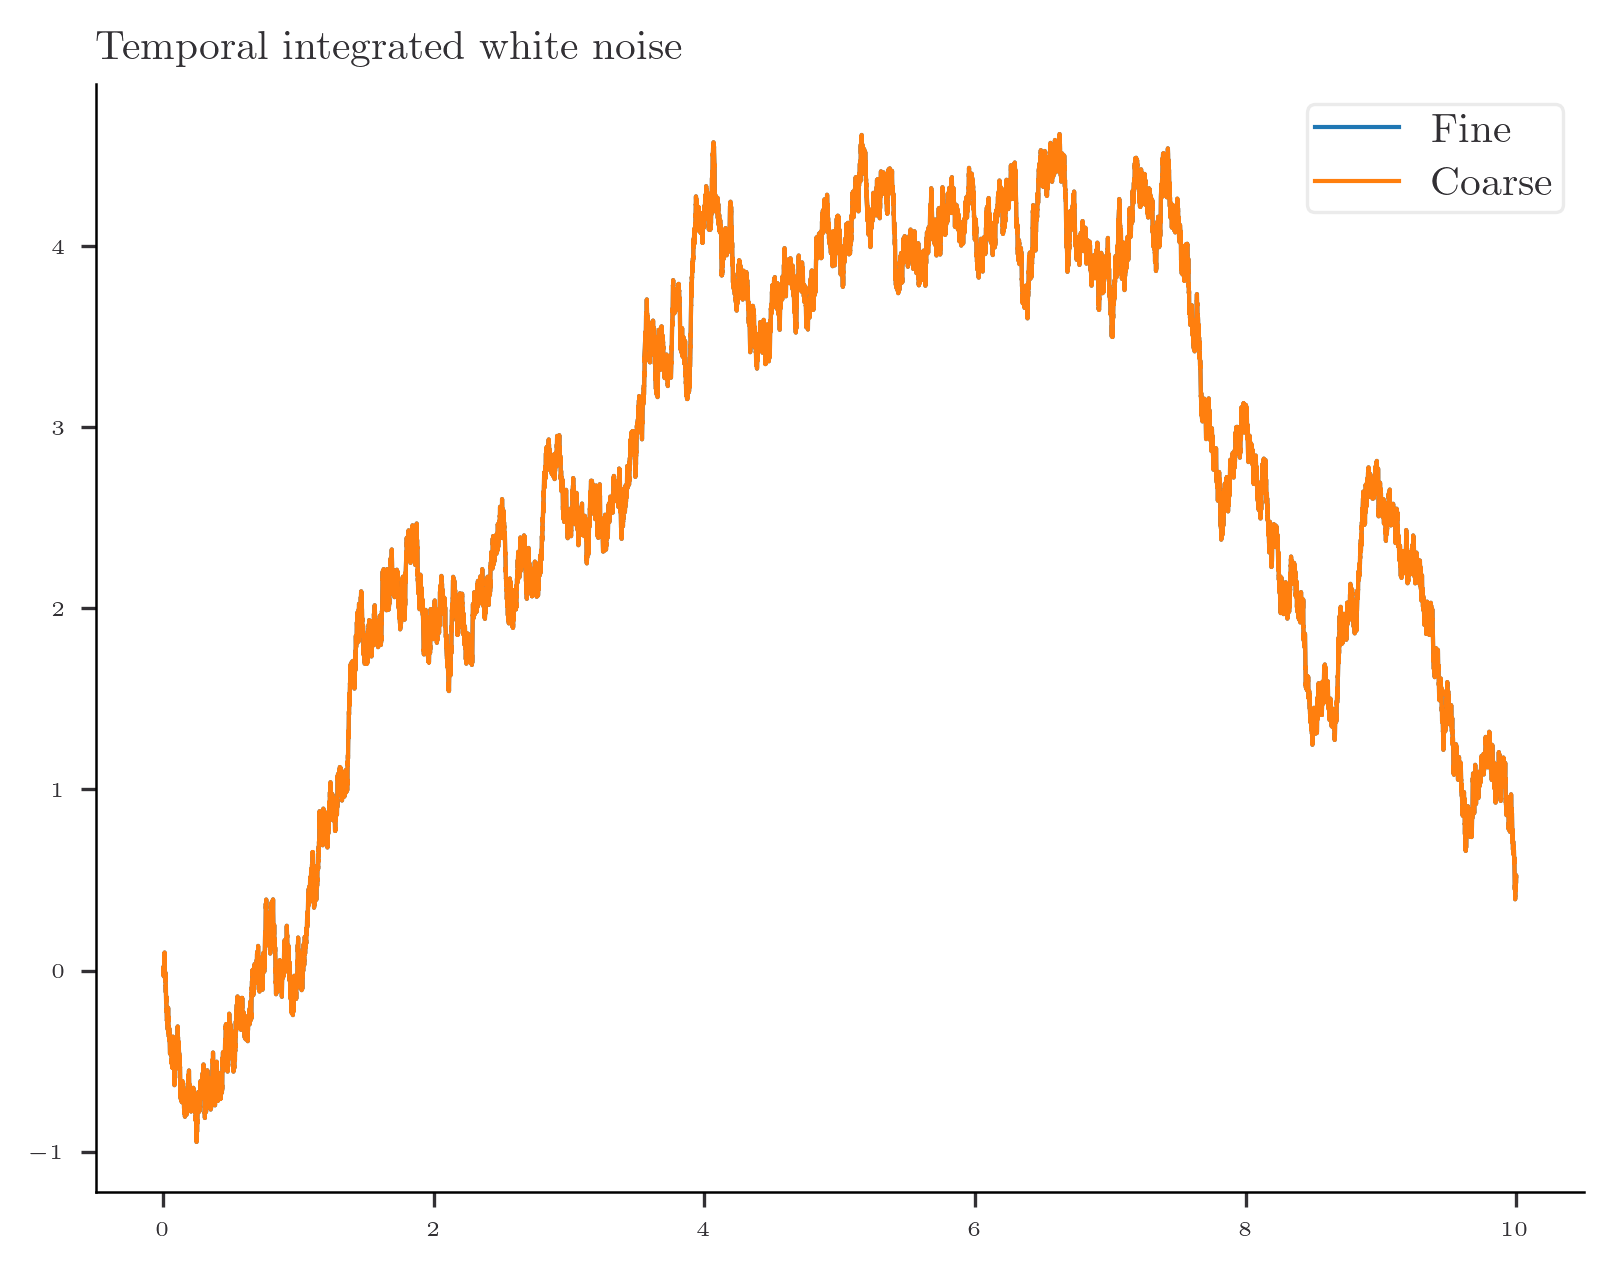

In [29]:
plt.plot(time_span_spectral, jnp.cumsum(BM[1])*jnp.sqrt(h_spectral), label = "Fine")
plt.plot(time_span, jnp.cumsum(BM_coarse[1])*jnp.sqrt(h), label = "Coarse")
plt.title("Temporal integrated white noise")
plt.legend()

In [30]:
sigma, nu, h, h_spectral

(0.01, 0.0001, 0.000244140625, 0.000244140625)

In [31]:
start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span, h, linear_solver, g_tent,non_linear_init, sigma, xi_tent_coarse, tau, k_quad, tent_quad) 
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Number of integration steps 40960


40960it [01:06, 619.01it/s]


Time to integrate the system 73.64167


In [32]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [33]:
u_coarse = u_values_T[coarse_factor-1::coarse_factor]
compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span)

(Array(0.04994309, dtype=float64), Array(0.01878, dtype=float64))

In [34]:
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)

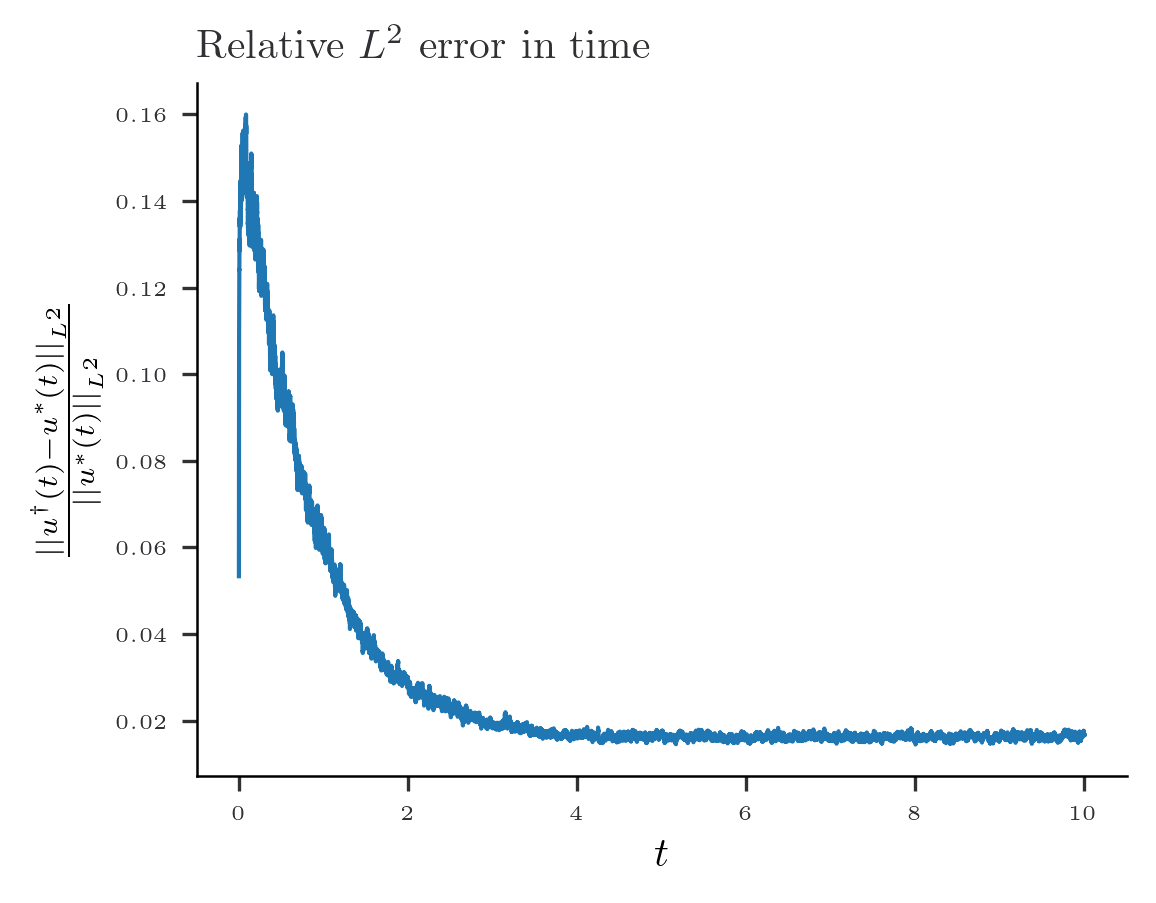

In [35]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span, rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

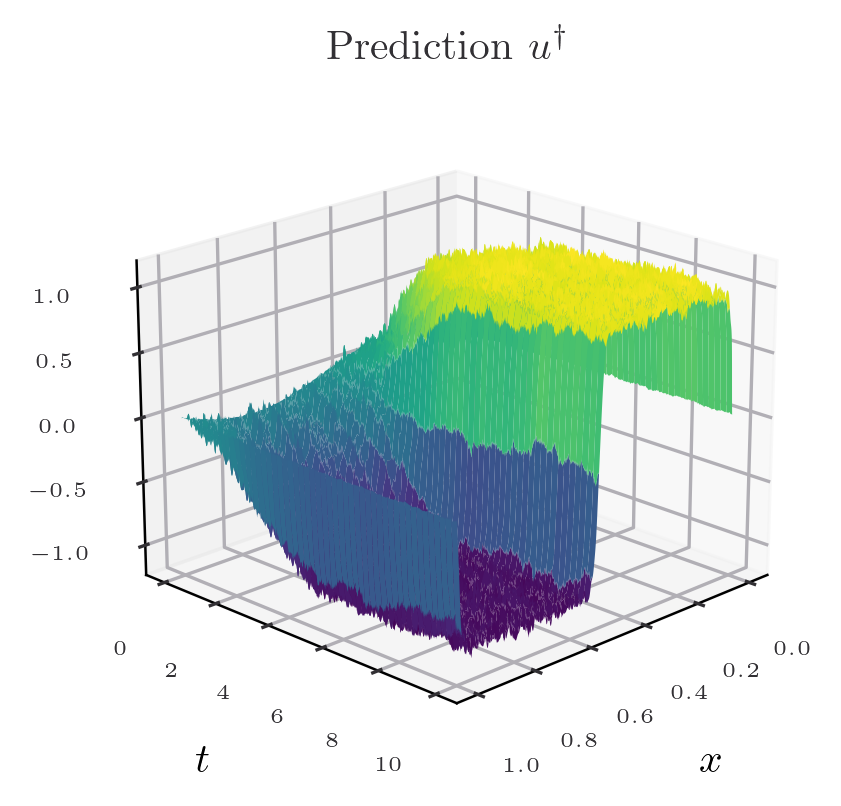

In [36]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
# stride = 25
# ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)


ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis')
ax.set_title(r"Prediction $u^\dagger$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

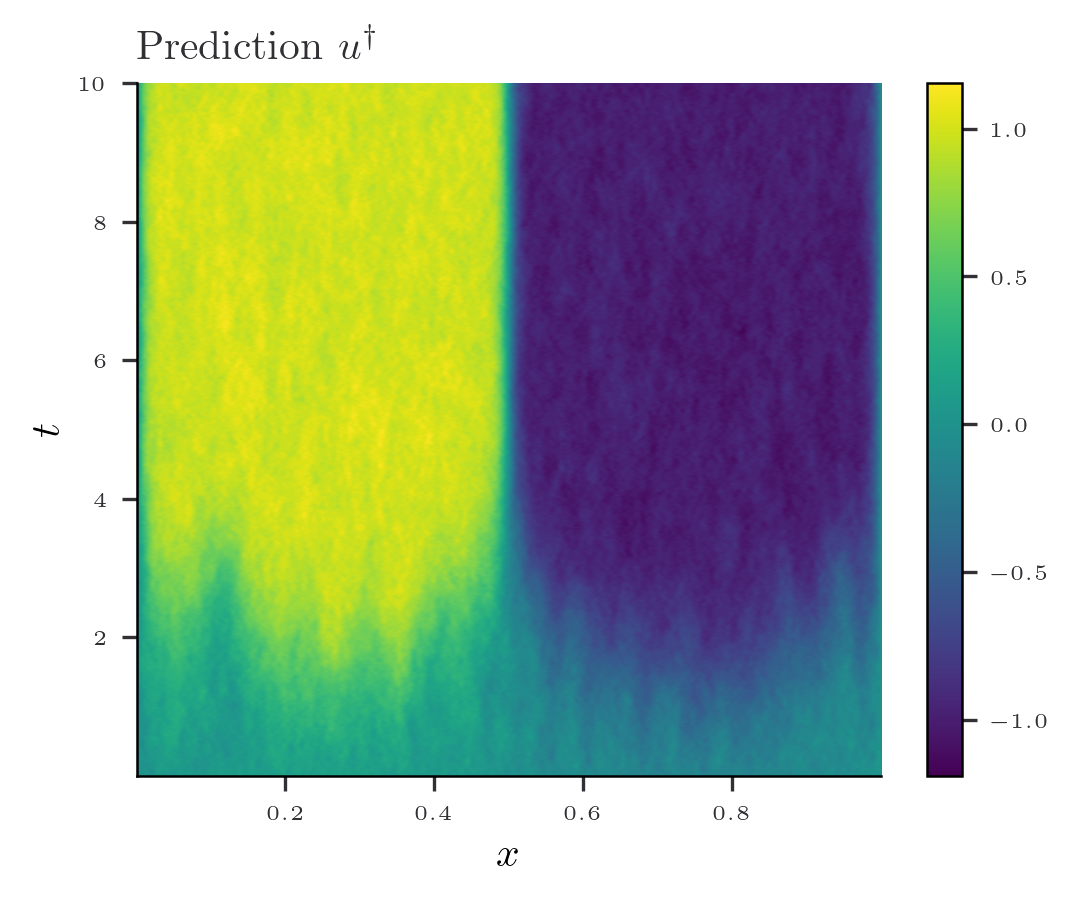

In [37]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

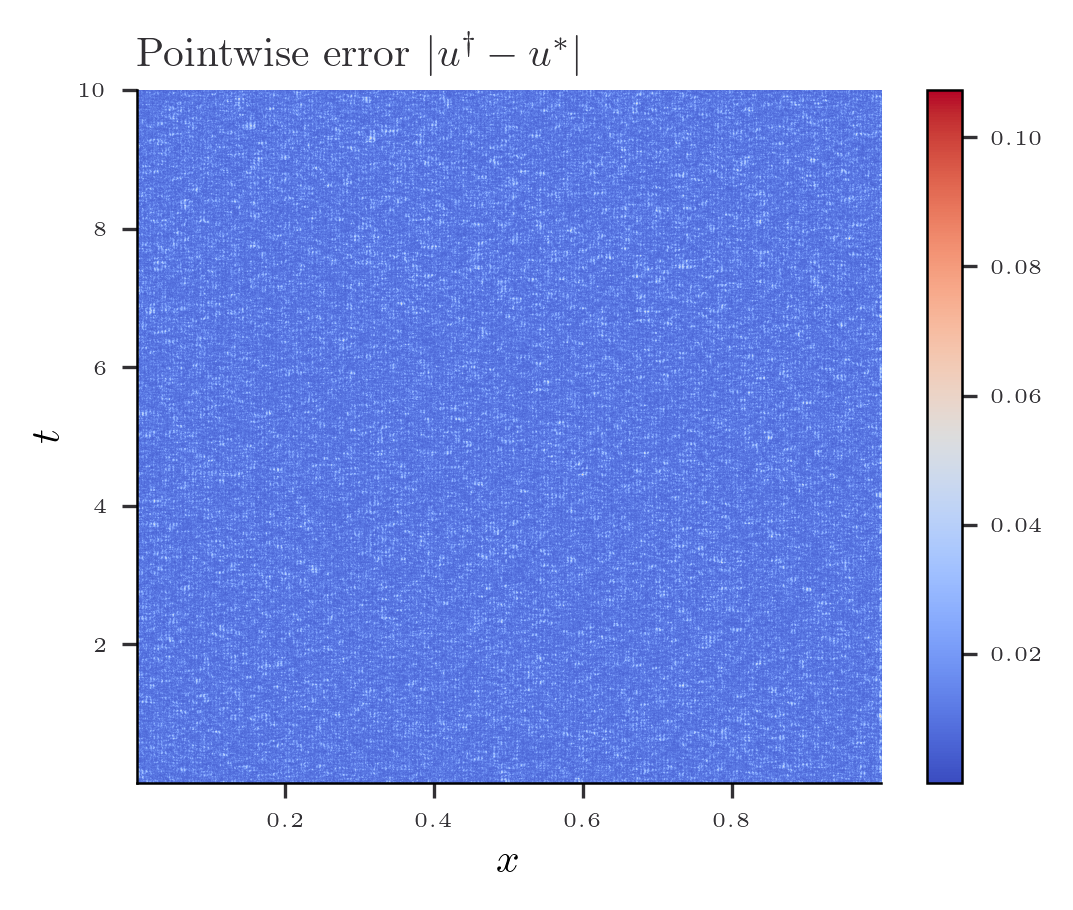

In [38]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_coarse), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Coarser in space and time

In [332]:
coarse_factor = 4 # Here the coarse factor is 1 (so we have the same resolution in time)
h = h_spectral*coarse_factor
time_span = jnp.arange(h, T+h, h)
time_span_spectral = jnp.arange(h_spectral, T+h_spectral, h_spectral)
cfl_factor = 5

In [333]:
# Generate our Galerkin basis
n_intervals = int(jnp.sqrt(1/h))*cfl_factor + 1
n_meas = n_intervals -1 # We do not include the boundary points
print(n_meas)
epsilon = (upper- lower)/n_intervals
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

160


In [357]:
from utils_rough_pde import vmap_root_interval
from scipy.special import roots_legendre

n_quad = 5
print(n_quad*2-1)
x_q, w_q = roots_legendre(n_quad)
# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))


# Quadrature node for the kernel
x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
k_quad = []
for i in range(n_meas):
    k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
k_quad = jnp.array(k_quad)

9


In [358]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])

In [359]:
@jit
def integrate_f_test_functions(f_values, psi):
    # Psi should be a matrix containing the values of the weighted test functions at the quadrature points
    return f_values@psi
vmap_integrate_f_test_functions = jit(vmap(integrate_f_test_functions, in_axes=(0,None)))

In [360]:
g_quad = jnp.sqrt(2)*jnp.sin(2*jnp.pi*k_quad)*0.1
non_linear_init =integrate_f_test_functions(tau(g_quad), tent_quad) 
g_proj = integrate_f_test_functions(g_quad, tent_quad)

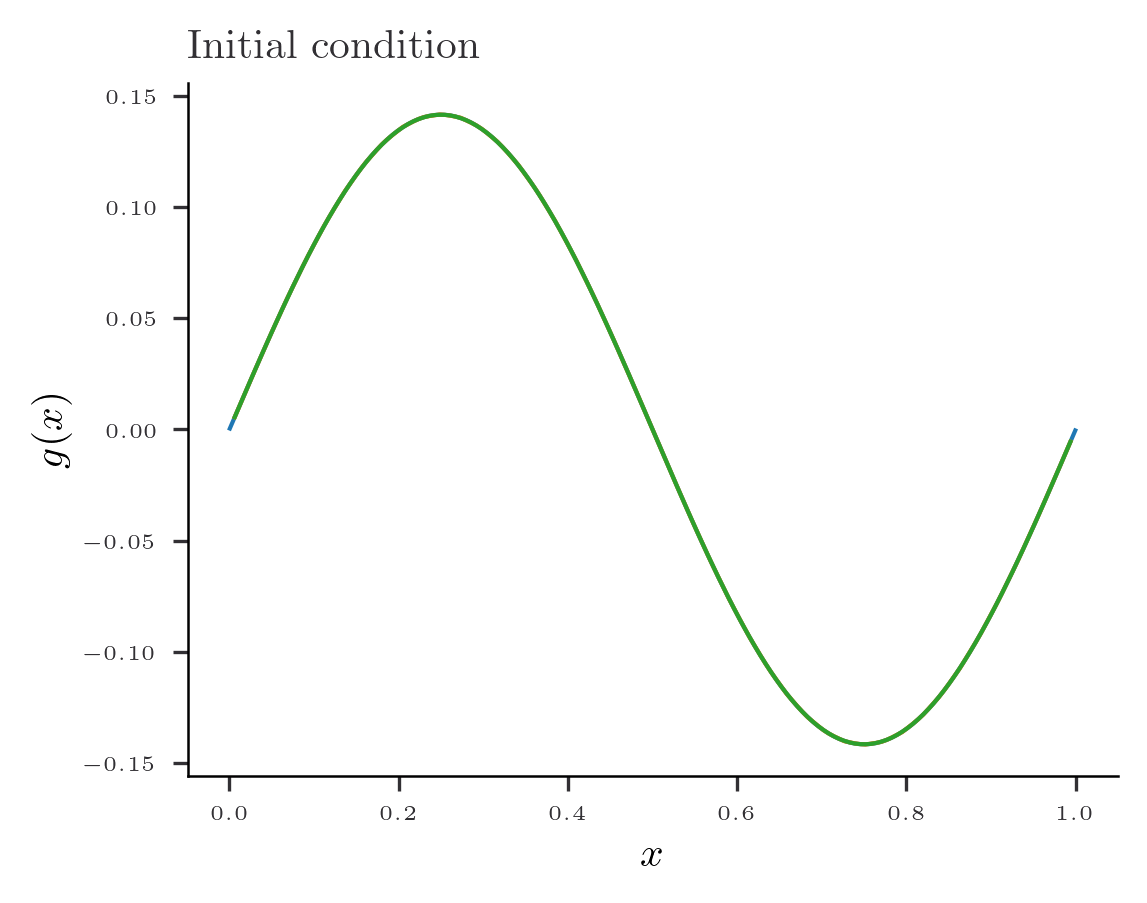

In [361]:
tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
g_tent = tent_proj_coef@coef_g # We can now project the initial condition onto the tent functions

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, g_values)
plt.plot(centers[1:-1], g_tent)
plt.plot(centers[1:-1], g_proj)
plt.xlabel(r"$x$")
plt.ylabel(r"$g(x)$")
plt.title(r"Initial condition")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

In [362]:
b =lambda x : jnp.ones_like(x)*(1-h)
root_b= b(k_quad)
length_scale = 0.01
k_quad.shape

(160, 10)

In [363]:
linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)


start = time.time()
linear_solver.build_matrices(root_b)
linear_solver.create_K_psi()
linear_solver.create_K_eval(domain_finest)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

Time to build the matrices 0.01922


In [364]:
BM_coarse = BM.reshape(n_coef, time_span_spectral.shape[0] // coarse_factor, coarse_factor)
BM_coarse = jnp.sum(BM_coarse, axis = -1)/jnp.sqrt(coarse_factor)
xi_tent_coarse = tent_proj_coef@BM_coarse
white_noise = vmap_dst(BM.T)

In [365]:
tent_proj_coef.shape, BM_coarse.shape

((160, 2048), (2048, 10240))

In [366]:
BM_coarse.shape, xi_tent_coarse.shape, BM.shape

((2048, 10240), (160, 10240), (2048, 40960))

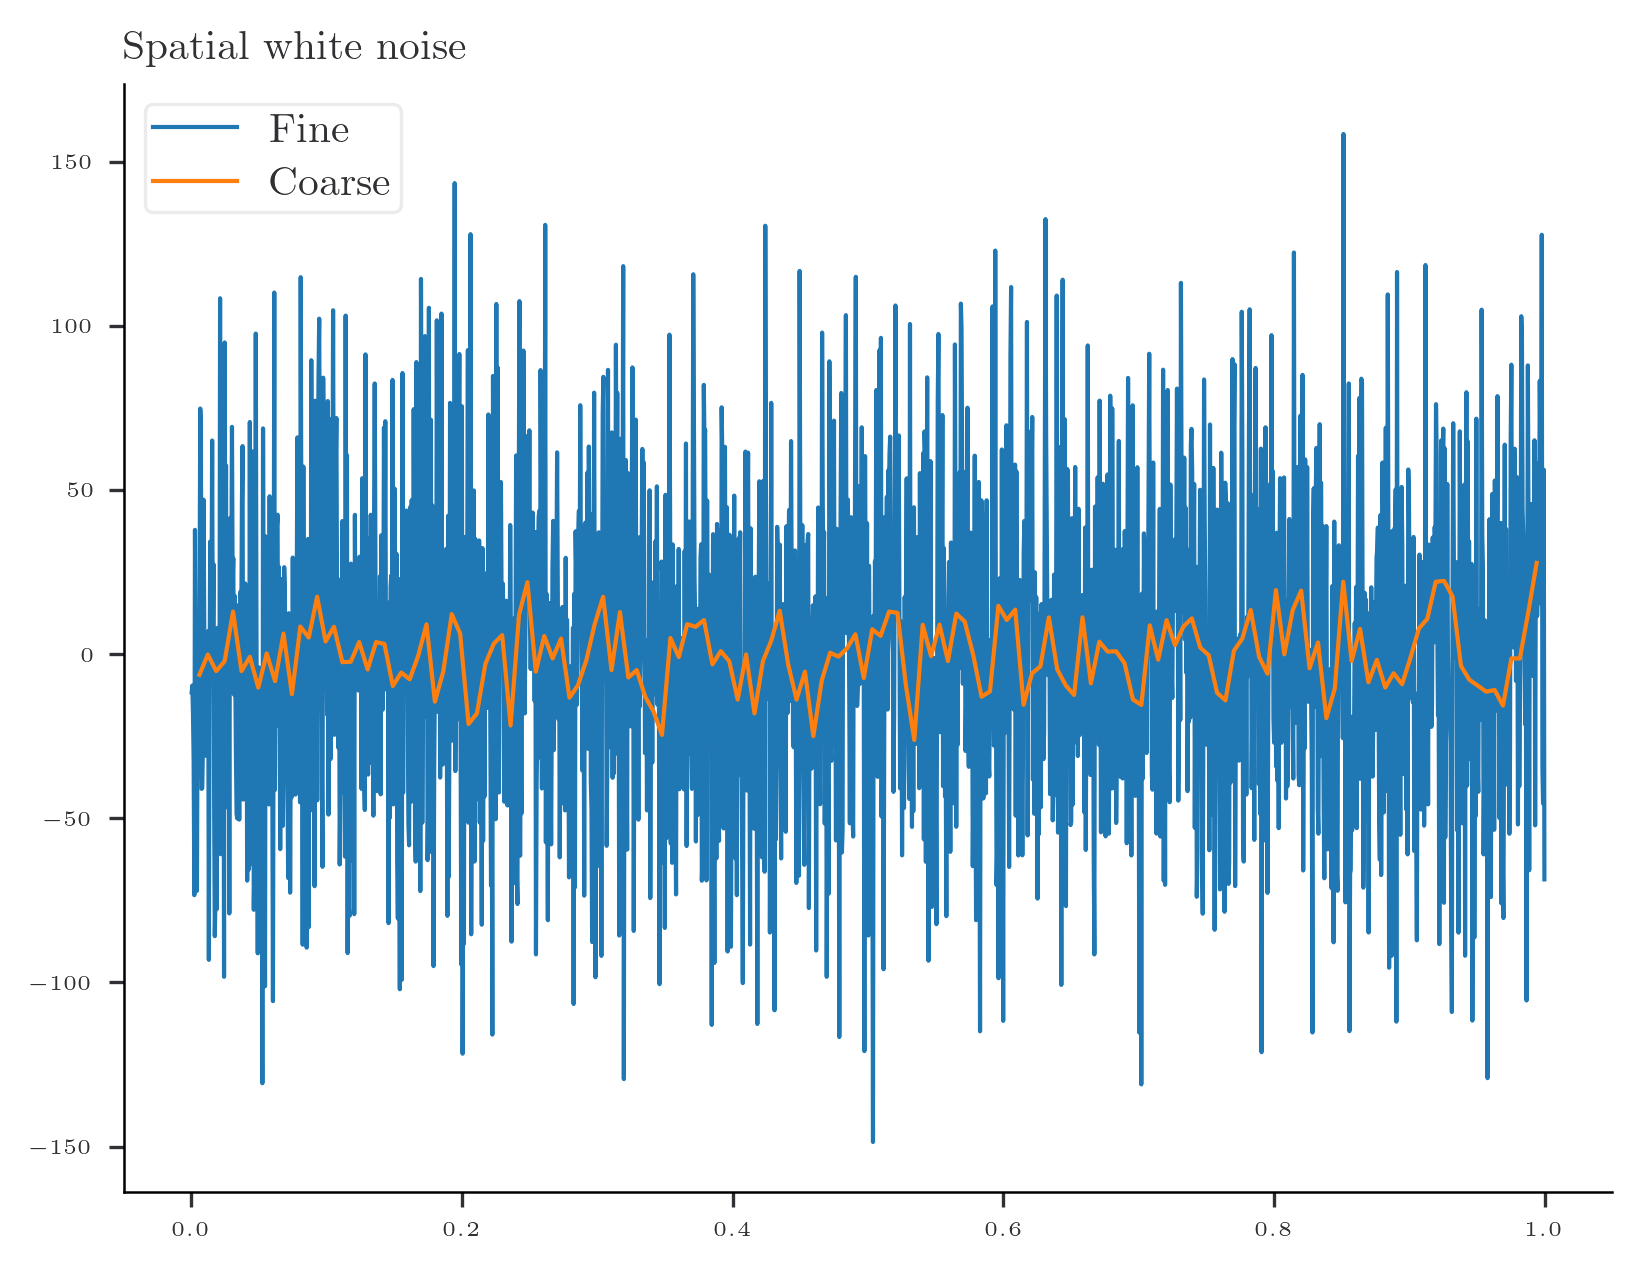

In [367]:
plt.plot(domain_finest, white_noise[0], label = "Fine")
plt.plot(centers[1:-1], xi_tent_coarse[:, 0], label = "Coarse")
plt.legend()
plt.title("Spatial white noise")
plt.show()

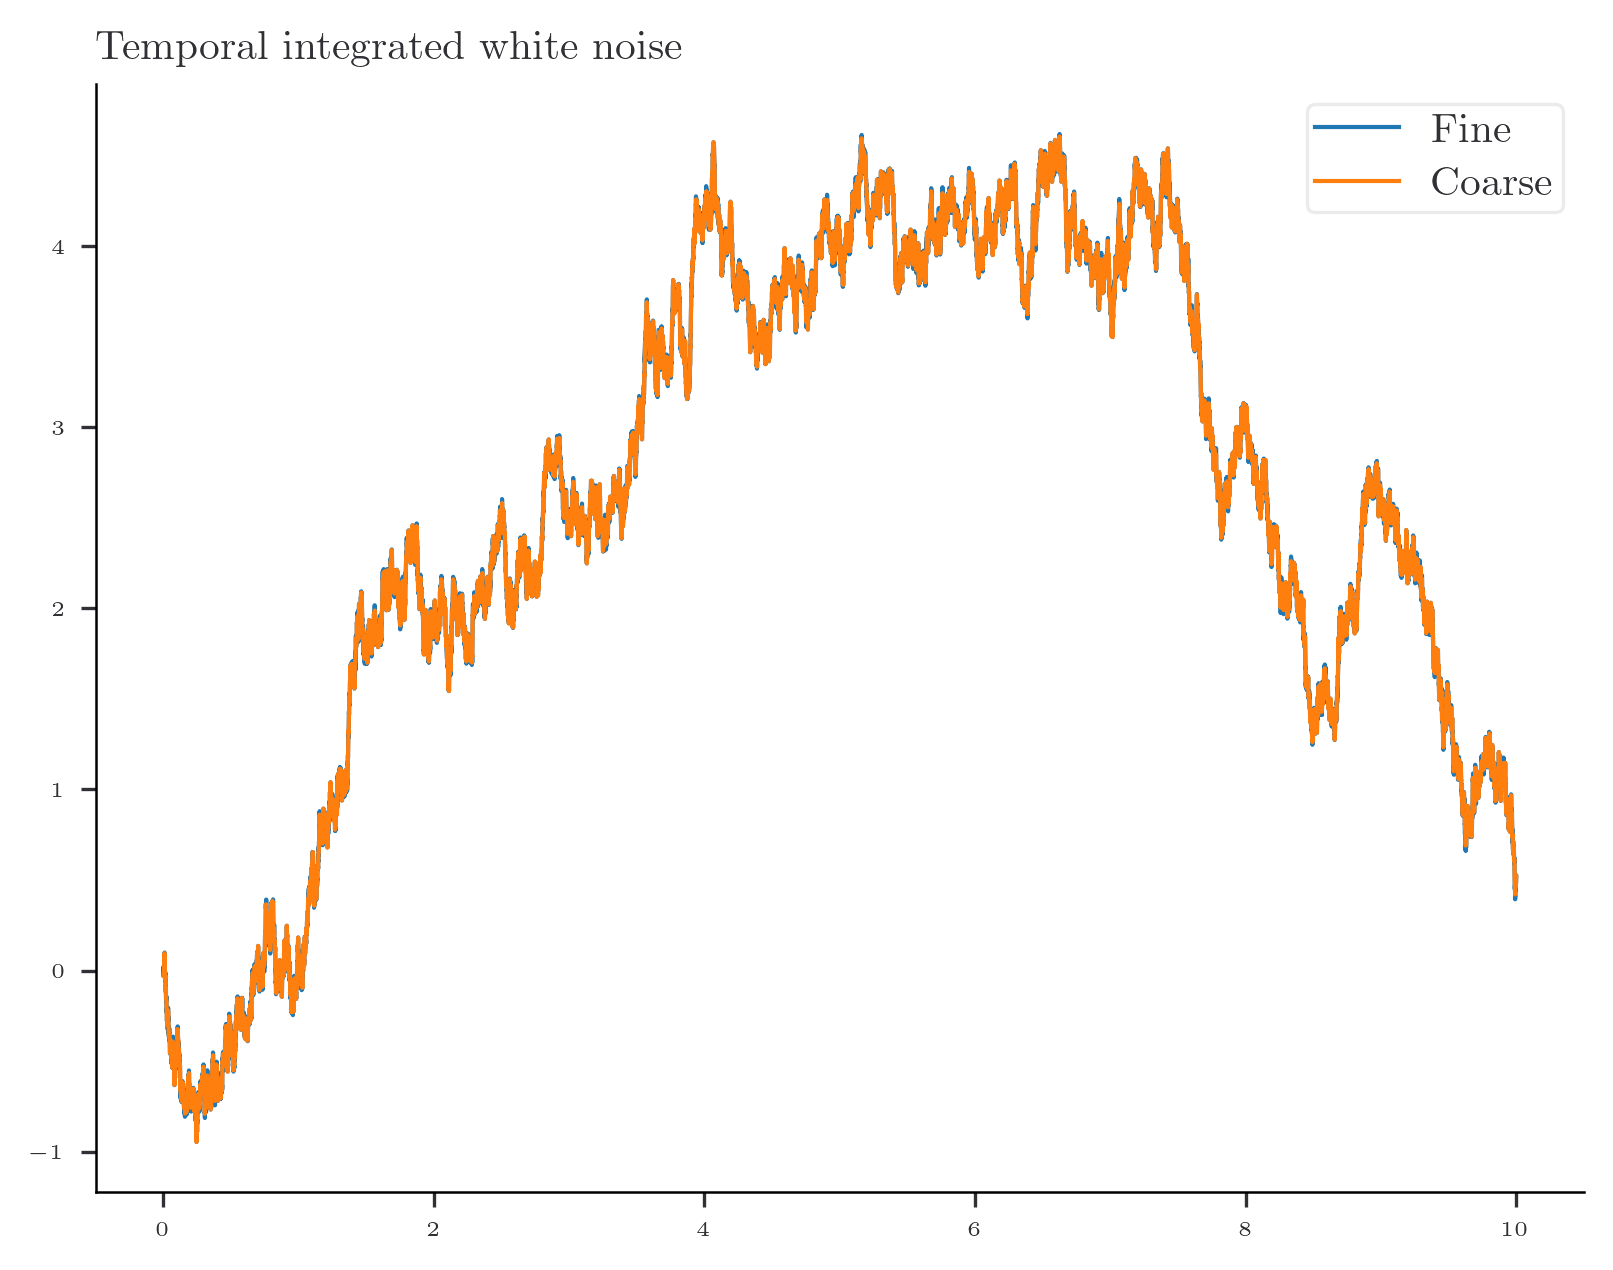

In [368]:
plt.plot(time_span_spectral, jnp.cumsum(BM[1])*jnp.sqrt(h_spectral), label = "Fine")
plt.plot(time_span, jnp.cumsum(BM_coarse[1])*jnp.sqrt(h), label = "Coarse")
plt.title("Temporal integrated white noise")
plt.legend()

In [369]:
sigma, nu, h, h_spectral

(0.01, 0.0001, 0.0009765625, 0.000244140625)

In [370]:
start = time.time()
#y, linear_solver, c_kernel_history= implicit_EM_solver(time_span, h, linear_solver, g_tent,non_linear_init, sigma, xi_tent_coarse, tau, k_quad, tent_quad) 
y, linear_solver, c_kernel_history= implicit_EM_solver(time_span, h, linear_solver, g_proj,non_linear_init, sigma, xi_tent_coarse, tau, k_quad, tent_quad) 
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Number of steps 10240


10240it [00:16, 604.14it/s]


Time to integrate the system 18.813260000000003


In [371]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [356]:
u_coarse = u_values_T[coarse_factor-1::coarse_factor]
compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span)

(Array(0.05509184, dtype=float64), Array(0.02071612, dtype=float64))

In [350]:
error_T, rel_error_T = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)

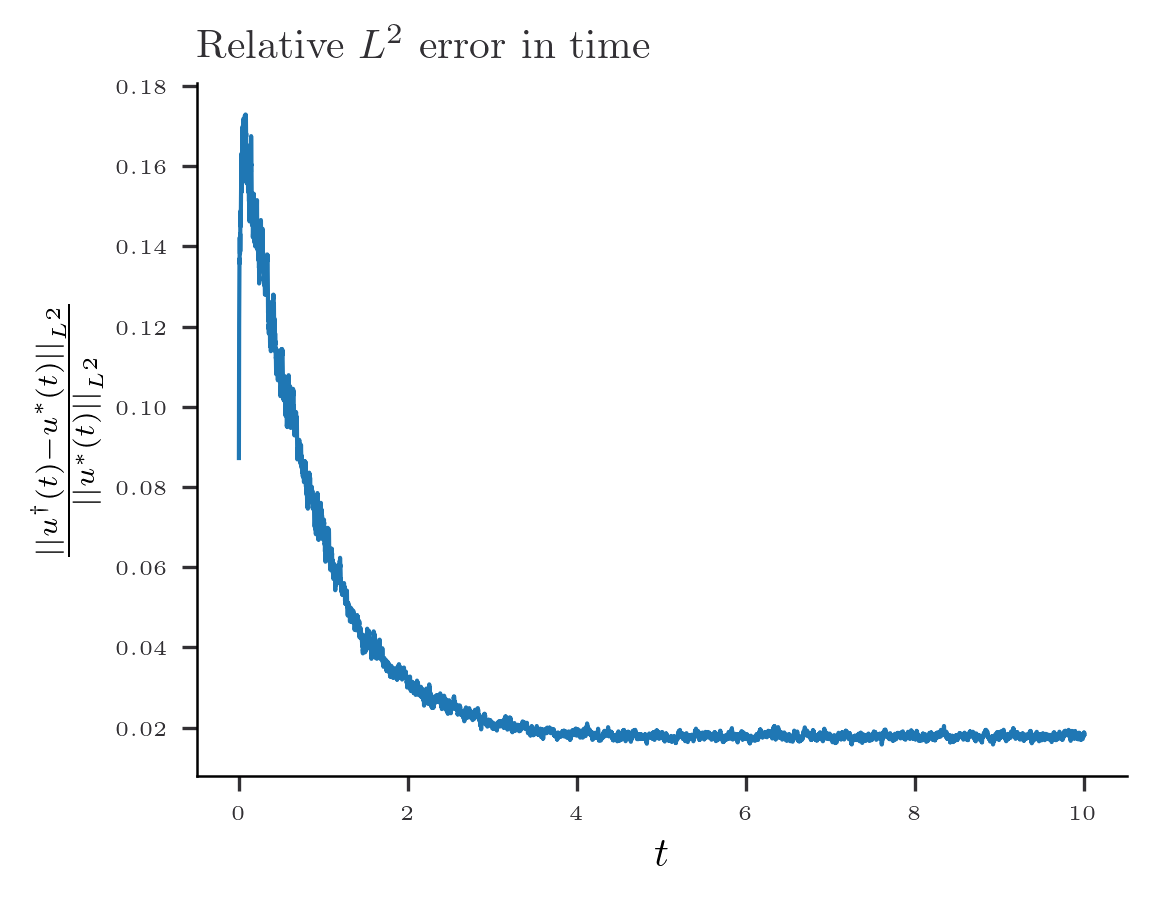

In [351]:
# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(time_span, rel_error_T)
plt.xlabel(r"$t$")
plt.ylabel(r"$\frac{||u^\dagger(t)-u^*(t) ||_{L^2}}{||u^*(t)||_{L^2}}$")
plt.title(r"Relative $L^2$ error in time")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

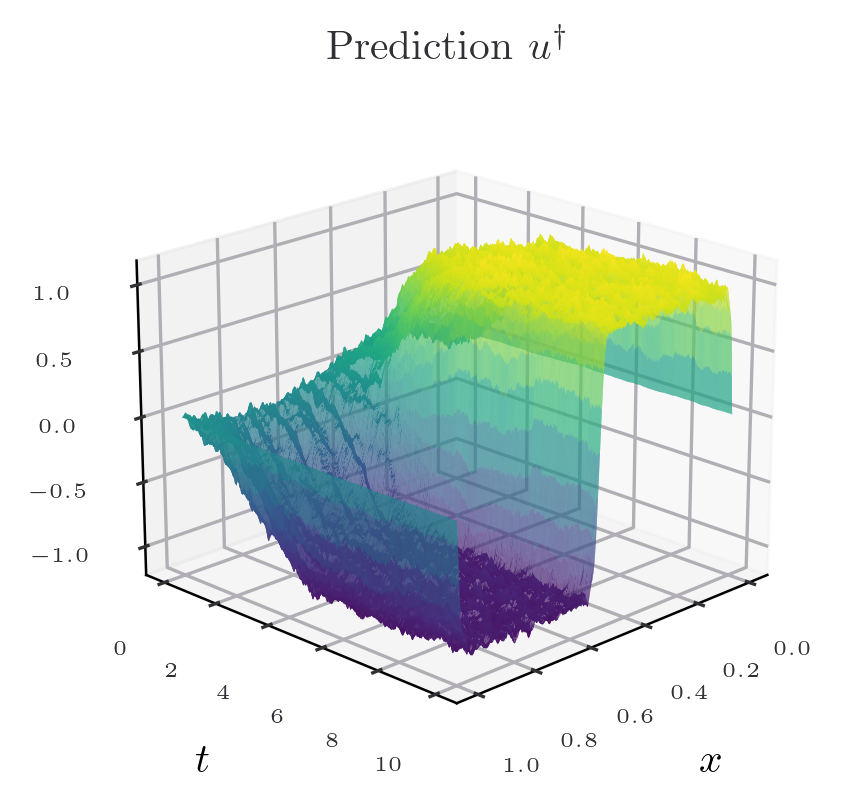

In [396]:

# Create a figure with two 3D subplots
fig,ax = plt.subplots(1, 1, figsize=(width, height), subplot_kw={'projection': '3d'})

X, time_grid = jnp.meshgrid(domain_finest, time_span)
stride = 10
ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis',  rstride=stride, cstride=stride)


#ax.plot_surface(X, time_grid, pred_kernel,  cmap='viridis')
ax.set_title(r"Prediction $u^\dagger$")
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuthal angle as desired
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
plt.show()

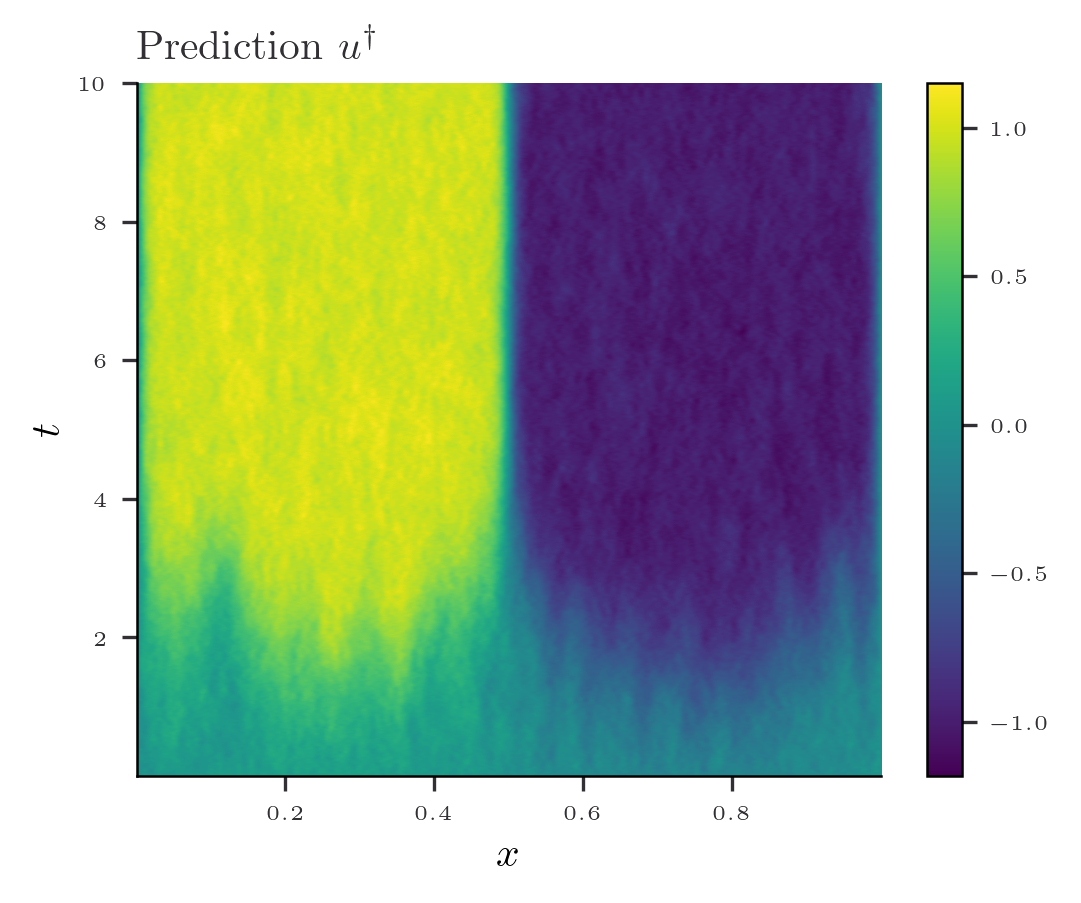

In [353]:
fig = plt.figure(figsize=(width, height))

plt.imshow(pred_kernel[::-1], cmap='viridis', extent=[domain_finest.min(), domain_finest.max(), time_span[1:].min(), time_span[1:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Prediction $u^\dagger$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

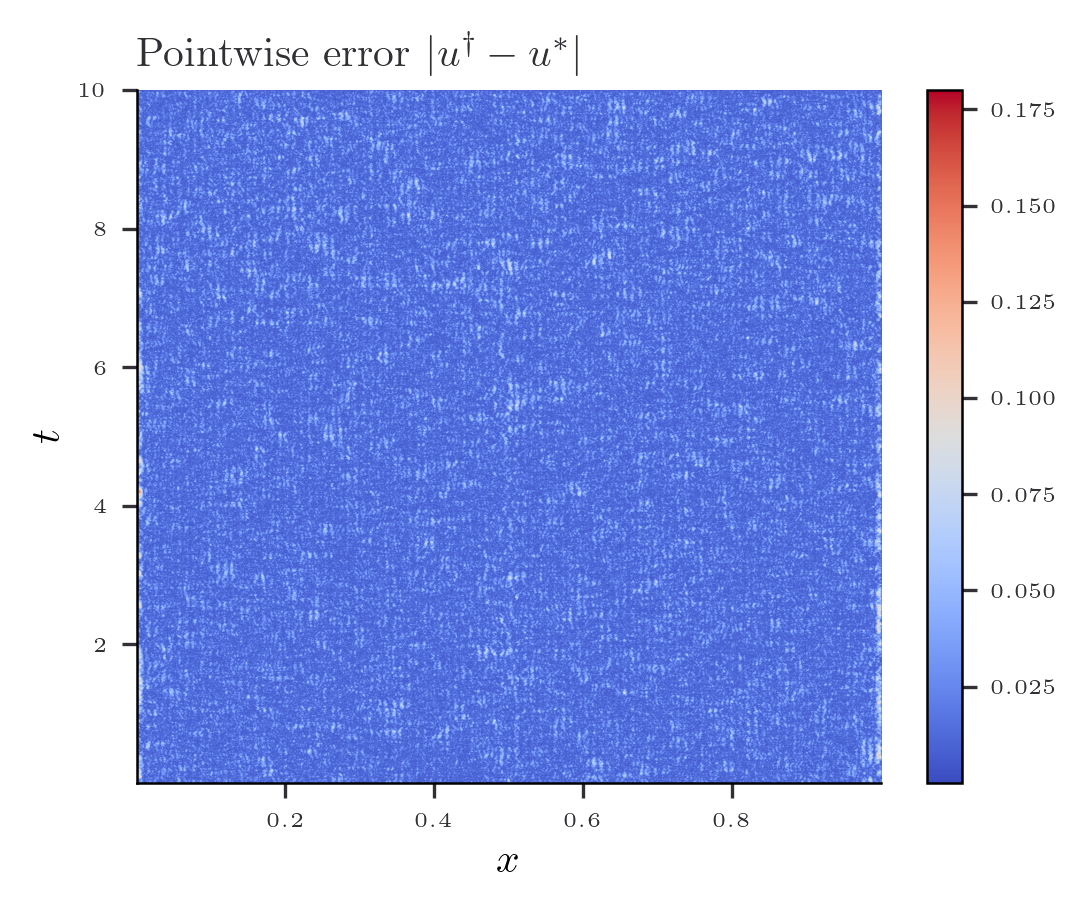

In [394]:
fig = plt.figure(figsize=(width, height))

plt.imshow(jnp.abs(pred_kernel - u_coarse), cmap='coolwarm', extent=[domain_finest.min(), domain_finest.max(), time_span[:].min(), time_span[:].max()], aspect='auto')

# Set the axis labels (optional)
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(r'Pointwise error $|u^\dagger - u^*|$')

# Display the plot
plt.colorbar()  # Add a colorbar for reference
plt.show()

# Computing error rates

In [ ]:
n_quad = 5
x_q, w_q = roots_legendre(n_quad)

# Quadrature node for the tent element
x_element, w_element = root_interval(x_q, w_q, jnp.array([0, 1]))

cfl_factor = 3

In [ ]:
# The fundamental element
def tent_element(x, normalization = 1.0):
    
    element = jnp.maximum(0, 1 + (x - 1) )
    

    # Set the element to zero outside the interval
    element = jnp.where(x < 0.0, 0.0, element)
    element = jnp.where(x > 1.0, 0.0, element)

    return element/normalization

element_quad = tent_element(x_element, normalization = 1.0)
tent_quad = jnp.hstack([element_quad, element_quad[::-1]])*jnp.hstack([w_element, w_element[::-1]])
time_span_spectral = jnp.arange(h_spectral, T+h_spectral, h_spectral)

In [385]:
h_list = jnp.array([2**i*h_spectral for i in range(2,8)])[::-1]
h_list, jnp.sqrt(1/h_list)*cfl_factor

(Array([0.03125   , 0.015625  , 0.0078125 , 0.00390625, 0.00195312,
        0.00097656], dtype=float64),
 Array([16.97056275, 24.        , 33.9411255 , 48.        , 67.88225099,
        96.        ], dtype=float64))

In [386]:
length_scale = 0.01

In [387]:
coarse_list = jnp.array([2**i for i in range(2, 9)])[::-1]
error_list = []
error_list_r = []
error_time = []
for coarse_factor in coarse_list:
    print(coarse_factor)
    h = coarse_factor*h_spectral
    n_meas = int(jnp.sqrt(1/h)*cfl_factor)

    # Generate our Galerkin basis
    n_intervals = n_meas +1
    n_meas = n_intervals -1 # We do not include the boundary points

    epsilon = (upper- lower)/n_intervals
    centers = jnp.linspace(lower, upper, n_intervals + 1)
    epsilon = (upper - lower)/n_intervals
    epsilon_values  = jnp.ones(n_intervals)*epsilon
    intervals = jnp.array([centers[:-1], centers[1:]]).T

    # Quadrature node for the kernel
    x_quad, w_quad = vmap_root_interval(x_q, w_q, intervals)
    k_quad = []
    for i in range(n_meas):
        k_quad.append(jnp.hstack([x_quad[i], x_quad[i+1]]))
    k_quad = jnp.array(k_quad)

    # For the linear part
    b =lambda x : jnp.ones_like(x)*(1-h)
    root_b= b(k_quad)

    # Project the initial condition on the Galerkin basis
    g_quad = jnp.sqrt(2)*jnp.sin(2*jnp.pi*k_quad)*0.1
    non_linear_init =integrate_f_test_functions(tau(g_quad), tent_quad) 
    g_proj = integrate_f_test_functions(g_quad, tent_quad)

    # Coarsen the Wiener process
    tent_values = vmap_tent(domain_finest, epsilon, centers[1:-1]) # Evaluate the tent functions on the fine grid
    tent_proj_coef = vmap_compute_sine_coef(tent_values)  # Project the tent functions onto the sine basis
    BM_coarse = BM.reshape(n_coef, time_span_spectral.shape[0] // coarse_factor, coarse_factor)
    BM_coarse = jnp.sum(BM_coarse, axis = -1)/jnp.sqrt(coarse_factor)
    xi_tent_coarse = tent_proj_coef@BM_coarse
    #print(BM_coarse.shape, xi_tent_coarse.shape)



    linear_solver = kernel_linear_solver(length_scale, tent_quad, k_quad,  boundary[:, None], boundary_conditions, h*nu)
    linear_solver.build_matrices(root_b)
    linear_solver.create_K_psi()
    linear_solver.create_K_eval(domain_finest)

    # Integrate
    time_span = jnp.arange(h, T+h, h)
    #print(h, n_meas, time_span.shape[0])
    y, linear_solver, c_kernel_history= implicit_EM_solver(time_span, h, linear_solver, g_proj,non_linear_init, sigma, xi_tent_coarse, tau, k_quad, tent_quad) 

    pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)
    u_coarse = u_values_T[coarse_factor-1::coarse_factor]
    e, e_r = compute_2d_error(pred_kernel, u_coarse, domain_finest, time_span)
    error_list.append(e)
    error_list_r.append(e_r)

    e_t , _  = vmap(compute_1d_error, in_axes=(0, 0, None))(pred_kernel, u_coarse, domain_finest)
    error_time.append(e_t)


256
Number of steps 160


160it [00:00, 257.20it/s]


128
Number of steps 320


320it [00:00, 352.58it/s]


64
Number of steps 640


640it [00:01, 448.68it/s]


32
Number of steps 1280


1280it [00:02, 559.79it/s]


16
Number of steps 2560


2560it [00:04, 578.57it/s]


8
Number of steps 5120


5120it [00:08, 636.75it/s]


4
Number of steps 10240


10240it [00:15, 648.63it/s]


In [388]:
error = jnp.array(error_list)
error_rel = jnp.array(error_list_r)
max_error_time =jnp.array([jnp.max(e) for e in error_time])
error, error_rel, max_error_time

(Array([2.63469655, 1.81637729, 0.50629062, 0.23168865, 0.11597839,
        0.08981959, 0.07194633], dtype=float64),
 Array([0.99062153, 0.68296146, 0.19037458, 0.08712091, 0.04361129,
        0.03377477, 0.0270539 ], dtype=float64),
 Array([0.9774635 , 0.69639986, 0.22252722, 0.08821981, 0.0435966 ,
        0.03375387, 0.02634051], dtype=float64))

In [389]:
max_error_time

Array([0.9774635 , 0.69639986, 0.22252722, 0.08821981, 0.0435966 ,
       0.03375387, 0.02634051], dtype=float64)

In [390]:
meas_list = []
for coarse_factor in coarse_list:
        h = coarse_factor*h_spectral
        n_meas = jnp.sqrt(1/h)*cfl_factor
        meas_list.append(T/h*n_meas)
meas_list = jnp.array(meas_list)
meas_list

Array([  1920.        ,   5430.58007951,  15360.        ,  43444.6406361 ,
       122880.        , 347557.12508881, 983040.        ], dtype=float64)

In [391]:
# Estimate the convergence rate by fitting a line to the log-log plot of the error
log_n_meas = jnp.log(meas_list)
log_error = jnp.log(error)

a = jnp.hstack([log_n_meas.reshape(-1, 1), jnp.ones_like(log_n_meas.reshape(-1, 1))])
b_2 = log_error
r, C = jnp.linalg.lstsq(a, b_2)[0]
r, C = -r.item(), jnp.exp(C).item()

print("L^2 Convergence rate: ", jnp.round(r,3)) 

L^2 Convergence rate:  0.628


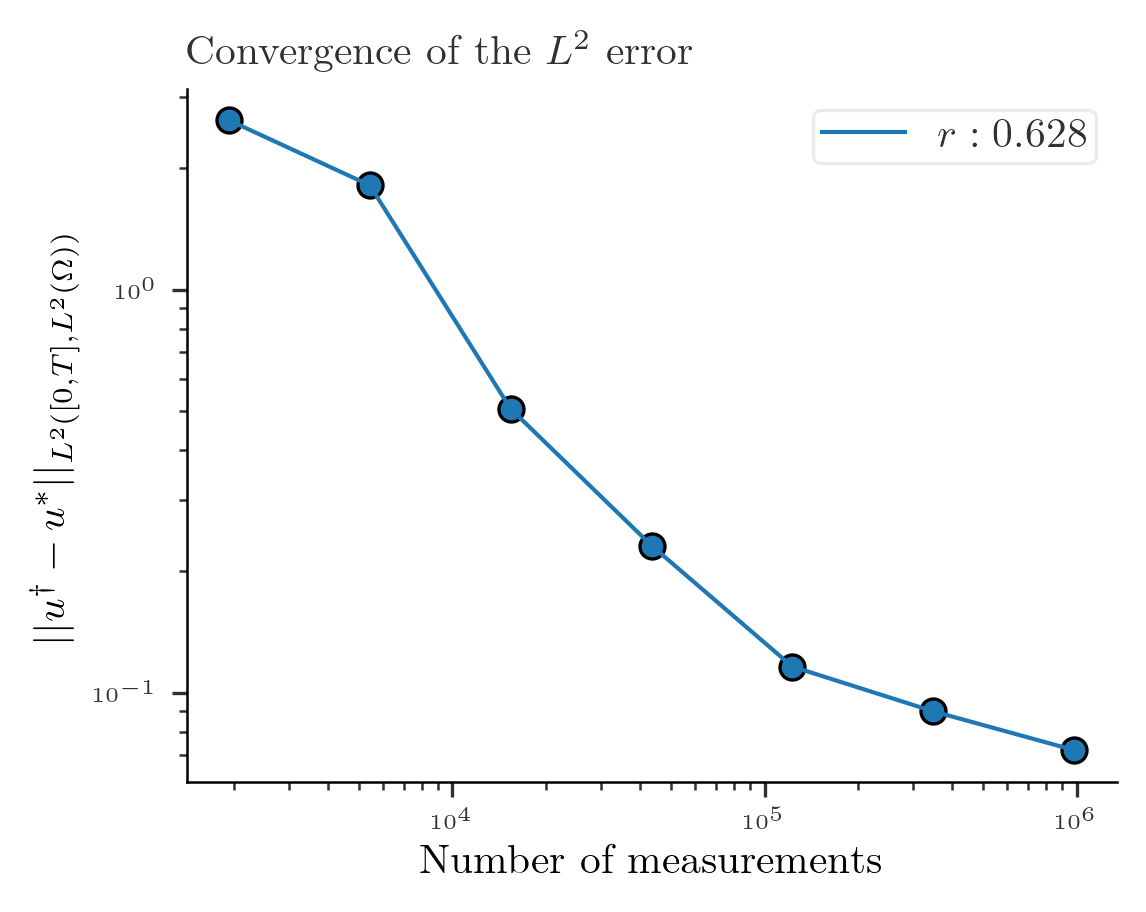

In [392]:
fig = plt.figure(figsize=(width, height))
plt.plot(meas_list, error, label = r"$r :{:.03f}$".format(r))
plt.scatter(meas_list, error)
plt.yscale('log')
plt.xscale('log')

plt.xlabel("Number of measurements")
plt.ylabel(r"$||u^\dagger - u^*||_{L^2([0, T], L^2(\Omega))}$")
plt.title(r"Convergence of the $L^2$ error")
plt.legend()

plt.show()
